# 6053 Final Project

## Group Members

- Willem Mirkovich (`wjm9297`)
- Alec Pippas (`awp251`) 
- Sudhanshu Sali (`ss17526`)

## Question

What is the influence of median income on the number of fast food restaurants in a region?

The hypothesis we want to test is that as median income (I) increases in Metropolitan Counties, there is an increase in the fast food restaurant count (F). Conversely, when the median income (I) increases in Micropolitan Counties, there is a decrease in the fast food restaurant count (F), which we think is similar to the [food desert phenomenon in the US](https://en.wikipedia.org/wiki/Food_desert).

## Data

Our data comes from a few different sources to create a simple table where we have a [Core Based Statistical Area](https://en.wikipedia.org/wiki/Core-based_statistical_area)
correlated with whether the area is metropolitan/micropolitan in addition to the number of fast food restaurants in the given area.

- Tigerline Core Based Statistical Area Boundaires w/ Micropolitan/Metropolitan classification for 2019
    - Source: https://www2.census.gov/geo/tiger/TIGER2019/CBSA/
- US Census Median Household Income Estimated for Core Based Statistical Areas 2019
    - Source: https://data.census.gov/table/ACSST1Y2019.S2503?q=United States&t=Financial Characteristics&g=010XX00US,$3100000&y=2019
- US Fast Food Restaurant Locations Updated as of November, 2018
    - Source: https://hub.arcgis.com/datasets/UrbanObservatory::fast-food-restaurants/explore?layer=0&showTable=true

## Notebook Setup

In [40]:
# imports
import httpx
import math
import geopandas as gpd
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import networkx as nx

from cartopy.feature import LAND
from shapely import bounds, Polygon
from scipy import stats
from os import path, mkdir

az.rcParams["stats.hdi_prob"] = 0.89 

In [2]:
# utility functions

def standardize(series):
    return (series - series.mean()) / series.std()

def polygon_to_extent(polygon: Polygon):
    b = bounds(polygon)
    return [b[0], b[2], b[1], b[3]]

def create_cartopy_plot(figsize=(12, 8), title=None):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.add_feature(LAND)

    if title:
        ax.set_title(title)

    return fig, ax

## Causal Model

The DAG explains the three variables:
- Treatment Variable: Median Income (I)
- Outcome Variable: Fast Food Restaurant Count (F)
- Primary Confounder: Metropolitan/ Micropolitan Status (M)

![](./static/dag.png)

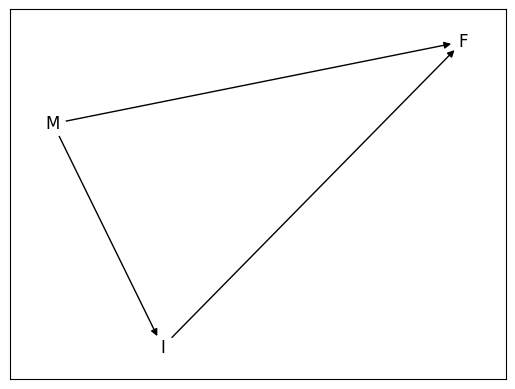

In [45]:
G = nx.DiGraph()

G.add_edge('I', 'F')
G.add_edge('M', 'F')
G.add_edge('M', 'I')

fig, ax = plt.subplots(1, 1)

nx.draw_networkx(G, node_color='white', arrows=True, ax=ax)

## Data Prep

To create the final dataset we are interested in for this project, we need to join the three separate data sources

1. Load geospatial US county data that has both the metropolitan/micropolitan flag as well as geospatial boundary of the county
2. Load median household income estimates for the given counties by name
3. Join the above two datasets by county name, only including counties where a median household income is available
4. Load the fast food restaurant location data, which provides latitude/longitude coordinates of where each restaurant exists
5. Join the fast food restaurant location data with our county table, via a geospatial join where a lat/lon is inside a county boundary
6. Group the final table by county name, where we aggregate by the count of fast food restaurants that are within a given county

In [3]:
# Load CBSA geospatial information
def get_cached_file(file_name: str, download_url: str, file_handler):
    temp_dir = './temp'
    if not path.exists(temp_dir):
        mkdir(temp_dir)
    file_path = f'{temp_dir}/{file_name}'
    if not path.exists(file_path):
        resp = httpx.get(download_url)
        if resp.status_code == 200:
            with open(file_path, 'wb') as f:
                f.write(resp.content)
        else:
            resp.raise_for_status()
    return file_handler(file_path)

# https://www2.census.gov/geo/tiger/TIGER2019/CBSA/
area_gdf = get_cached_file('tl_2019_us_cbsa.zip', 'https://www2.census.gov/geo/tiger/TIGER2019/CBSA/tl_2019_us_cbsa.zip', gpd.read_file).to_crs(4326)
area_gdf = area_gdf.rename(columns={
    'NAMELSAD': 'area_name',
    'LSAD': 'area_flag'
})
area_gdf = area_gdf[['area_name', 'area_flag', 'geometry']]
area_gdf

,area_name,area_flag,geometry
0,"Athens-Clarke County, GA Metro Area",M1,"POLYGON ((-83.53739 33.96591, -83.53184 33.968..."
1,"Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,"POLYGON ((-85.33823 33.65312, -85.33842 33.654..."
2,"Atlantic City-Hammonton, NJ Metro Area",M1,"POLYGON ((-74.85675 39.42076, -74.85670 39.420..."
3,"Atmore, AL Micro Area",M2,"POLYGON ((-87.61542 31.04100, -87.61541 31.041..."
4,"Auburn, IN Micro Area",M2,"POLYGON ((-85.19295 41.38001, -85.19296 41.381..."
...,...,...,...
933,"Winfield, KS Micro Area",M2,"POLYGON ((-97.15084 37.30371, -97.15085 37.304..."
934,"Winnemucca, NV Micro Area",M2,"POLYGON ((-118.87429 40.96103, -118.87600 40.9..."
935,"Winona, MN Micro Area",M2,"POLYGON ((-92.07851 44.02033, -92.07860 44.023..."
936,"Winston-Salem, NC Metro Area",M1,"POLYGON ((-80.45170 36.26150, -80.45170 36.261..."


In [4]:
# Load census data for CBSAs
# NOTE: Median Household Income Estimate column: S2503_C01_013E

# NOTE: zip downloaded from source and unzipped to dir
income_df = pd.read_csv('data/income_data_2019/ACSST1Y2019.S2503-Data.csv').loc[1:].rename(columns={
    'S2503_C01_013E': 'median_household_income_est',
    'NAME': 'area_name'
})
income_df = income_df[['area_name', 'median_household_income_est']]
income_df

,area_name,median_household_income_est
1,United States,65712
2,"Aberdeen, WA Micro Area",61026
3,"Abilene, TX Metro Area",54808
4,"Adrian, MI Micro Area",53865
5,"Aguadilla-Isabela, PR Metro Area",16311
...,...,...
515,"York-Hanover, PA Metro Area",69172
516,"Youngstown-Warren-Boardman, OH-PA Metro Area",48558
517,"Yuba City, CA Metro Area",61307
518,"Yuma, AZ Metro Area",46419


In [5]:
# NOTE: inner join will drop any counties that do not have a median income estimate
area_gdf = pd.merge(area_gdf, income_df, how='inner')
area_gdf

,area_name,area_flag,geometry,median_household_income_est
0,"Athens-Clarke County, GA Metro Area",M1,"POLYGON ((-83.53739 33.96591, -83.53184 33.968...",50962
1,"Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,"POLYGON ((-85.33823 33.65312, -85.33842 33.654...",71742
2,"Atlantic City-Hammonton, NJ Metro Area",M1,"POLYGON ((-74.85675 39.42076, -74.85670 39.420...",63389
3,"Auburn, NY Micro Area",M2,"POLYGON ((-76.73797 42.96129, -76.73771 42.961...",58665
4,"Auburn-Opelika, AL Metro Area",M1,"POLYGON ((-85.29322 32.73073, -85.28826 32.730...",53712
...,...,...,...,...
513,"Wilmington, NC Metro Area",M1,"POLYGON ((-78.02992 34.33177, -78.03074 34.331...",57667
514,"Wilson, NC Micro Area",M2,"POLYGON ((-78.03802 35.78752, -78.03697 35.787...",38830
515,"Winchester, VA-WV Metro Area",M1,"POLYGON ((-78.50813 39.08863, -78.50853 39.088...",76583
516,"Winston-Salem, NC Metro Area",M1,"POLYGON ((-80.45170 36.26150, -80.45170 36.261...",52322


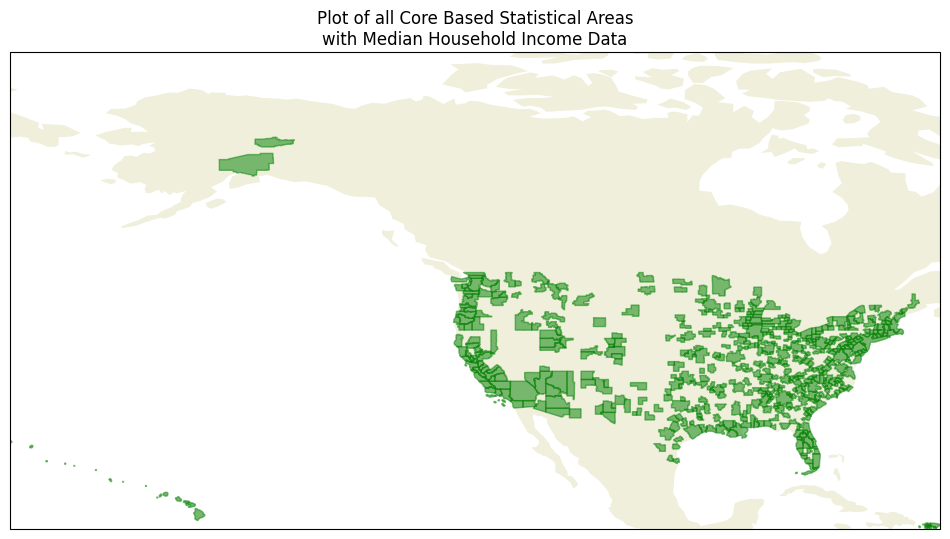

In [6]:
# plot of all areas with median income estimate
fig, ax = create_cartopy_plot(title='Plot of all Core Based Statistical Areas\nwith Median Household Income Data')
ax.add_geometries(area_gdf.geometry, color='green', alpha=.5, crs=ccrs.PlateCarree())
ax.set_extent(polygon_to_extent(area_gdf.geometry.unary_union))

In [7]:
# Load fast food location data

# NOTE: downloaded from source and saved to data directory as geojson
fast_food_gdf = gpd.read_file('data/fast_food_restaurants_20191107.geojson').set_crs(4326)
fast_food_gdf

,OBJECTID,ID,Letter,Address,City,State,Zip,Phone,Lat,Long_,Restaurant,geometry
0,1,1,b,3601 N.W. 27th Avenue,Miami,FL,33142,(305) 638-3838,25.8092,-80.2400,Burger King,POINT (-80.24000 25.80920)
1,2,2,b,8995 N. W. 7th Avenue,Miami,FL,33150,(305) 754-8453,25.8587,-80.2094,Burger King,POINT (-80.20940 25.85870)
2,3,3,b,30390 South Dixie Highway,Homestead,FL,33030,(305) 247-7181,25.4849,-80.4610,Burger King,POINT (-80.46100 25.48490)
3,4,4,b,7975 N. W. 27th Avenue,Miami,FL,33147,(305) 836-8152,25.8471,-80.2415,Burger King,POINT (-80.24150 25.84710)
4,5,5,b,9201 South Dixie Highway,Miami,FL,33156,(305) 666-1130,25.6849,-80.3125,Burger King,POINT (-80.31250 25.68490)
...,...,...,...,...,...,...,...,...,...,...,...,...
49997,49998,49998,w,Uscd Q-076 Price Center,La Jolla,CA,92093,None,32.8789,-117.2310,Wendy's,POINT (-117.23100 32.87890)
49998,49999,49999,w,Village At Wexford #278,Hilton Head Island,SC,29928,None,32.2162,-80.7098,Wendy's,POINT (-80.70980 32.21620)
49999,50000,50000,w,W V Rt 7,Morgantown,WV,26505,None,39.6321,-79.9568,Wendy's,POINT (-79.95680 39.63210)
50000,50001,50001,w,Westfall Town Ctr Rt 209,Matamoras,PA,18336,None,41.3709,-74.6981,Wendy's,POINT (-74.69810 41.37090)


/var/folders/l3/_57qjm850c7chfs8l26s8c500000gn/T/ipykernel_7843/708150327.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('plasma', len(colors))


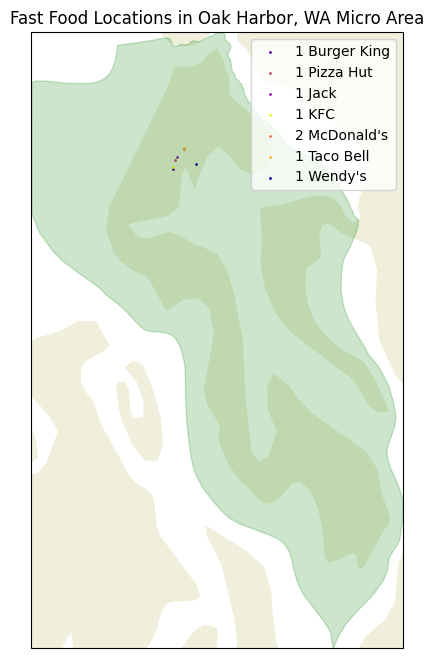

In [8]:
# quick sanity check that geospatial join will work 
area = 'Oak Harbor, WA Micro Area'
t = area_gdf[area_gdf.area_name == area].iloc[0]
area_ff = fast_food_gdf[fast_food_gdf.geometry.within(t.geometry)]
fig, ax = create_cartopy_plot(title=f'Fast Food Locations in {area}')

ax.add_geometries([t.geometry], color='green', alpha=.2, crs=ccrs.PlateCarree())
ax.set_extent(polygon_to_extent(t.geometry))

restaurants = area_ff.Restaurant.unique()
colors = np.random.choice(len(restaurants), len(restaurants), replace=False)
cmap = plt.cm.get_cmap('plasma', len(colors))
for (r, c) in zip(restaurants, colors):
    t = area_ff[area_ff.Restaurant == r]
    t.plot(ax=ax, markersize=1, color=cmap(c), label=f'{len(t)} {r}')

ax.legend()

In [9]:
# geospatial join of fast food on all areas
final_gdf = area_gdf.sjoin(fast_food_gdf, how='inner', predicate='covers')
final_gdf

,area_name,area_flag,geometry,median_household_income_est,index_right,OBJECTID,ID,Letter,Address,City,State,Zip,Phone,Lat,Long_,Restaurant
0,"Athens-Clarke County, GA Metro Area",M1,"POLYGON ((-83.53739 33.96591, -83.53184 33.968...",50962,28613,28614,28614,m,2063 Experiment Station Rd,Watkinsville,GA,30677,None,33.8724,-83.4391,McDonald's
0,"Athens-Clarke County, GA Metro Area",M1,"POLYGON ((-83.53739 33.96591, -83.53184 33.968...",50962,44146,44147,44147,w,1011 Jordan Drive,Athens,GA,30606,None,33.9153,-83.4461,Wendy's
0,"Athens-Clarke County, GA Metro Area",M1,"POLYGON ((-83.53739 33.96591, -83.53184 33.968...",50962,27760,27761,27761,m,1791 Epps Bridge Parkway,Athens,GA,30606,None,33.9159,-83.4447,McDonald's
0,"Athens-Clarke County, GA Metro Area",M1,"POLYGON ((-83.53739 33.96591, -83.53184 33.968...",50962,45846,45847,45847,w,1980 Barnett Shoals Rd,Athens,GA,30605,None,33.9206,-83.3421,Wendy's
0,"Athens-Clarke County, GA Metro Area",M1,"POLYGON ((-83.53739 33.96591, -83.53184 33.968...",50962,20675,20676,20676,k,2150 Barnett Shoals Rd,Athens,GA,30605,(706)549-4371,33.9222,-83.3413,KFC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,"Wisconsin Rapids-Marshfield, WI Micro Area",M2,"POLYGON ((-90.31566 44.51277, -90.31562 44.515...",56278,39552,39553,39553,t,1750 8th Street South,Wisconsin Rapids,WI,54494,(715)423-0690,44.3788,-89.8174,Taco Bell
517,"Wisconsin Rapids-Marshfield, WI Micro Area",M2,"POLYGON ((-90.31566 44.51277, -90.31562 44.515...",56278,20155,20156,20156,k,1750 8th Street South,Wisconsin Rapids,WI,54494,(715)423-0690,44.3788,-89.8174,KFC
517,"Wisconsin Rapids-Marshfield, WI Micro Area",M2,"POLYGON ((-90.31566 44.51277, -90.31562 44.515...",56278,31992,31993,31993,m,400 Daly Ave,Wisconsin Rapids,WI,54494-4744,None,44.3803,-89.8278,McDonald's
517,"Wisconsin Rapids-Marshfield, WI Micro Area",M2,"POLYGON ((-90.31566 44.51277, -90.31562 44.515...",56278,1607,1608,1608,b,940 Eighth Street South,Wisconsin Rapids,WI,54494,(715) 424-2070,44.3829,-89.8174,Burger King


In [10]:
# final groupby + aggregation to get restaurant count
final_gdf = final_gdf.groupby(['area_name', 'area_flag', 'median_household_income_est', 'geometry'])['Address'].count().to_frame().reset_index()
final_gdf = final_gdf.rename(columns={'Address': 'restaurant_count'})
final_gdf

,area_name,area_flag,median_household_income_est,geometry,restaurant_count
0,"Aberdeen, WA Micro Area",M2,61026,"POLYGON ((-124.30542 47.24464, -124.30637 47.2...",10
1,"Abilene, TX Metro Area",M1,54808,"POLYGON ((-100.14654 32.52279, -100.14642 32.5...",22
2,"Adrian, MI Micro Area",M2,53865,"POLYGON ((-84.36198 41.89876, -84.36198 41.898...",17
3,"Akron, OH Metro Area",M1,57158,"POLYGON ((-81.39169 41.34827, -81.39164 41.348...",146
4,"Alamogordo, NM Micro Area",M2,39371,"POLYGON ((-106.37642 32.91041, -106.37644 32.9...",9
...,...,...,...,...,...
505,"York-Hanover, PA Metro Area",M1,69172,"POLYGON ((-77.05440 40.02321, -77.05441 40.023...",58
506,"Youngstown-Warren-Boardman, OH-PA Metro Area",M1,48558,"POLYGON ((-81.00229 41.13419, -81.00232 41.145...",110
507,"Yuba City, CA Metro Area",M1,61307,"POLYGON ((-121.62376 39.29562, -121.62339 39.2...",23
508,"Yuma, AZ Metro Area",M1,46419,"POLYGON ((-114.76378 32.64340, -114.76342 32.6...",33


In [11]:
# sanity check: make sure top/bottom restaurant counts make sense
final_gdf.sort_values('restaurant_count', ascending=False).head(5)

,area_name,area_flag,median_household_income_est,geometry,restaurant_count
267,"Los Angeles-Long Beach-Anaheim, CA Metro Area",M1,77774,"MULTIPOLYGON (((-118.12590 33.69715, -118.1557...",2116
325,"New York-Newark-Jersey City, NY-NJ-PA Metro Area",M1,83160,"POLYGON ((-74.88982 40.78773, -74.88971 40.787...",1564
82,"Chicago-Naperville-Elgin, IL-IN-WI Metro Area",M1,75379,"POLYGON ((-88.60224 41.63139, -88.61185 41.631...",1315
108,"Dallas-Fort Worth-Arlington, TX Metro Area",M1,72265,"POLYGON ((-97.92164 33.00128, -97.92153 33.008...",993
201,"Houston-The Woodlands-Sugar Land, TX Metro Area",M1,69193,"POLYGON ((-95.80431 30.24557, -95.80429 30.247...",944


In [12]:
final_gdf.sort_values('restaurant_count', ascending=True).head(5)

,area_name,area_flag,median_household_income_est,geometry,restaurant_count
451,"Sunbury, PA Micro Area",M2,47349,"POLYGON ((-76.86143 41.03318, -76.86143 41.033...",7
362,"Port Angeles, WA Micro Area",M2,57126,"POLYGON ((-123.15163 47.86688, -123.15261 47.8...",8
425,"Shelton, WA Micro Area",M2,63983,"POLYGON ((-122.81343 47.30681, -122.81423 47.3...",8
26,"Auburn, NY Micro Area",M2,58665,"POLYGON ((-76.73797 42.96129, -76.73771 42.961...",8
330,"Oak Harbor, WA Micro Area",M2,72066,"POLYGON ((-122.86272 48.26269, -122.86273 48.2...",8


In [13]:
# save final table to csv
final_table = 'data/n_fast_food_by_cbsa.csv'
if not path.exists(final_table):
    final_gdf[['area_flag', 'median_household_income_est', 'restaurant_count']].to_csv(final_table, index=False)

## Data Exploration

In [14]:
df = pd.read_csv(final_table)
df = df.rename(columns={
    # rename to shorter names for convenience
    'median_household_income_est': 'median_income',
    'restaurant_count': 'ff_count'
})
df

,area_flag,median_income,ff_count
0,M2,61026,10
1,M1,54808,22
2,M2,53865,17
3,M1,57158,146
4,M2,39371,9
...,...,...,...
505,M1,69172,58
506,M1,48558,110
507,M1,61307,23
508,M1,46419,33


Text(0.5, 1.0, 'median income vs # fast food locations in micropolitan')

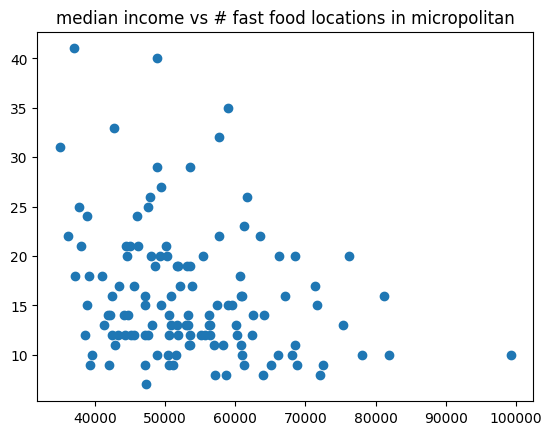

In [15]:
fig, ax = plt.subplots(1, 1)

temp = df[df.area_flag == 'M2']
ax.scatter(temp.median_income, temp.ff_count)
ax.set_title('median income vs # fast food locations in micropolitan')

Text(0.5, 1.0, 'median income vs # fast food locations in metropolitan')

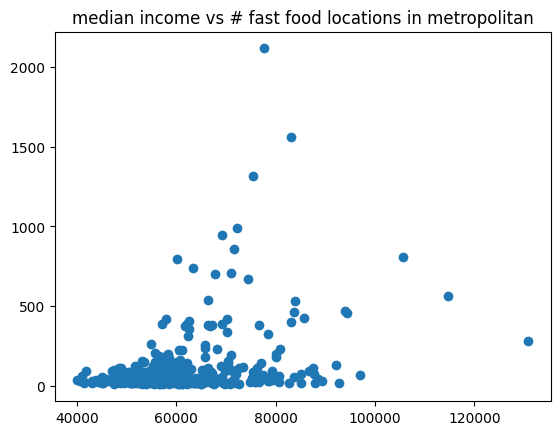

In [16]:
fig, ax = plt.subplots(1, 1)

temp = df[df.area_flag == 'M1']
ax.scatter(temp.median_income, temp.ff_count)
ax.set_title('median income vs # fast food locations in metropolitan')

Text(0.5, 1.0, 'median income metropolitan')

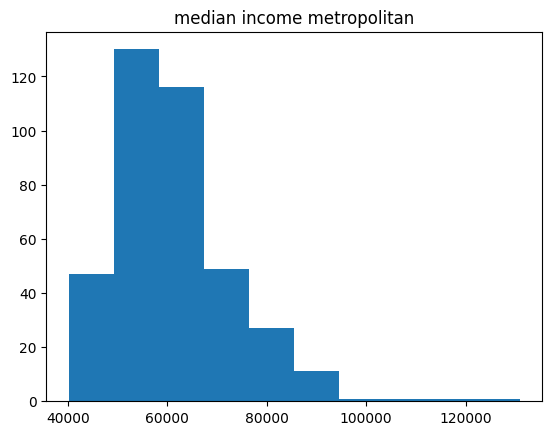

In [17]:
fig, ax = plt.subplots(1, 1)

temp = df[df.area_flag == 'M1']
ax.hist(temp.median_income)
ax.set_title('median income metropolitan')

Text(0.5, 1.0, 'median income micropolitan')

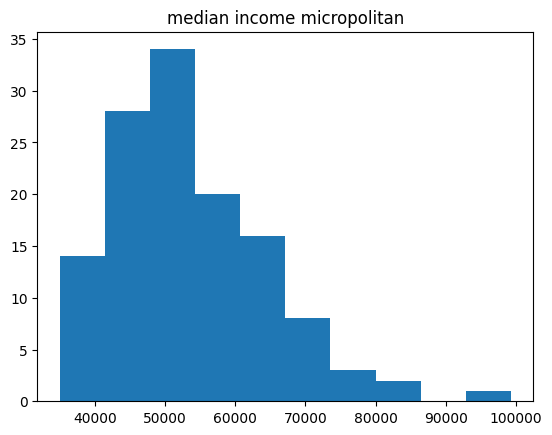

In [18]:
fig, ax = plt.subplots(1, 1)

temp = df[df.area_flag == 'M2']
ax.hist(temp.median_income)
ax.set_title('median income micropolitan')

In [19]:
df.area_flag.value_counts()

area_flag
M1    384
M2    126
Name: count, dtype: int64

## Prior Predictive Simulation

For our priors, we are pulling in the following assumptions

- Median income will follow a standard normal distribution, regardless of metropolitan/micropolitan, based on general knowledge of income in US
- There are more metropolitan areas collected vs micropolitan (3 - 1), as there is more population and better data for these regions
- Fast food restaurants will change depending on micro/metro. Due to food desserts in the US, we predict that 
micropolitan areas with lower income will have higher # of fast food locations, where as metro areas will follow a more standard increase. Both of these scenarios will be distributed in a [Log Normal Distribution](https://en.wikipedia.org/wiki/Log-normal_distribution), where many of the areas will have standard number, and a few locations will have large number of restaurants

<Axes: >

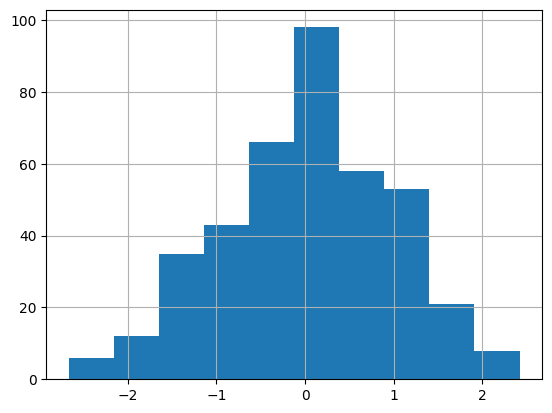

In [20]:
# Median income prior

income_sim = pd.Series(stats.norm.rvs(size=400))
income_sim.hist()

<Axes: >

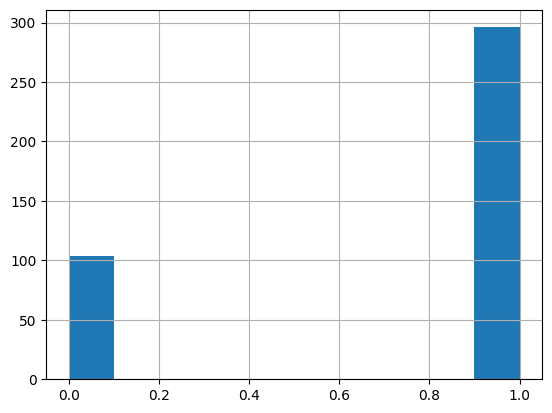

In [21]:
# Metro/Micro flag prior

flag_sim = pd.Series(stats.bernoulli.rvs(p=.75, size=400))
flag_sim.hist()

<Axes: >

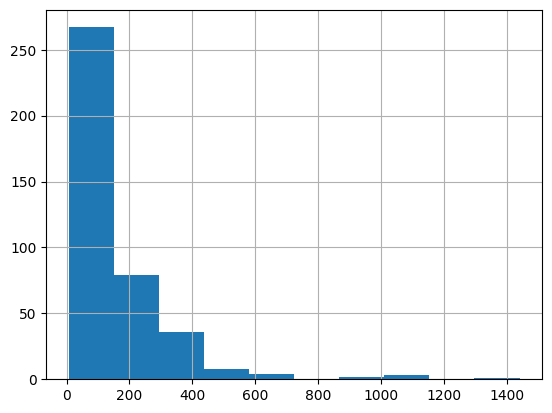

In [22]:
# Metro Restaurant count

# NOTE: higher variance in micro areas
metro_food_sim = pd.Series(stats.lognorm(s=1, scale=math.exp(4.5)).rvs(size=400))
metro_food_sim.hist()

<Axes: >

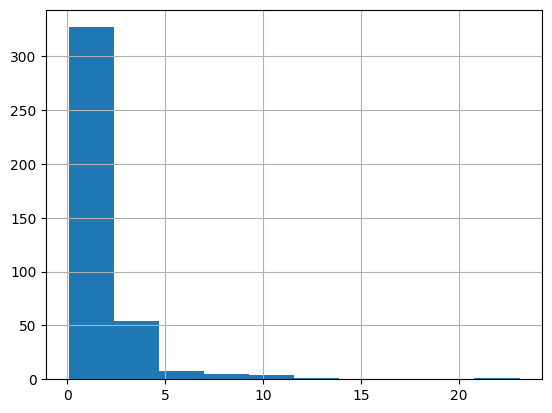

In [23]:
# Micro Restaurant count

# NOTE: lower variance in micro areas
metro_food_sim = pd.Series(stats.lognorm(s=1, scale=1).rvs(size=400))
metro_food_sim.hist()

In [24]:
def generate_data(size=400):
    i = pd.Series(stats.norm.rvs(size=size))
    m = pd.Series(stats.bernoulli.rvs(p=.75, size=size))
    f = []
    for flag in m:
        if flag == 1:
            f.append(stats.lognorm(s=1, scale=math.exp(4.5)).rvs(size=1)[0])
        else:
            f.append(stats.lognorm(s=1, scale=1).rvs(size=1)[0])

    df = pd.DataFrame({
        'I_sim': i,
        'M_sim': m,
        'F_sim': f
    })
    return df

sim = generate_data(size=500)
sim

,I_sim,M_sim,F_sim
0,0.392582,1,378.228001
1,-0.874223,1,18.854181
2,-0.249876,1,124.779541
3,1.492182,0,0.443221
4,-0.992319,1,29.691767
...,...,...,...
495,0.277314,1,31.821742
496,1.357498,1,156.230658
497,1.383930,1,8.853682
498,-1.286854,1,76.995388


Text(0.5, 1.0, 'median income vs # fast food locations in micropolitan')

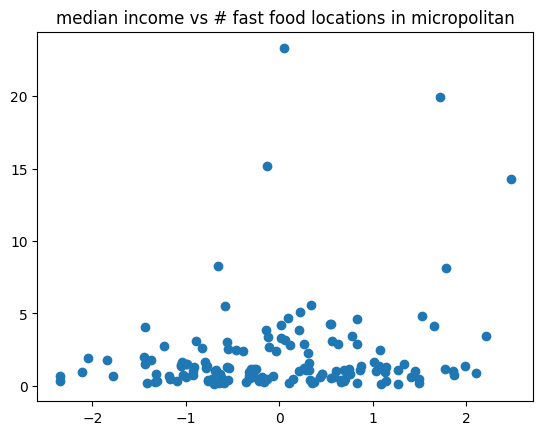

In [25]:
fig, ax = plt.subplots(1, 1)

temp = sim[sim.M_sim == 0]
ax.scatter(temp.I_sim, temp.F_sim)
ax.set_title('median income vs # fast food locations in micropolitan')

Text(0.5, 1.0, 'median income vs # fast food locations in metropolitan')

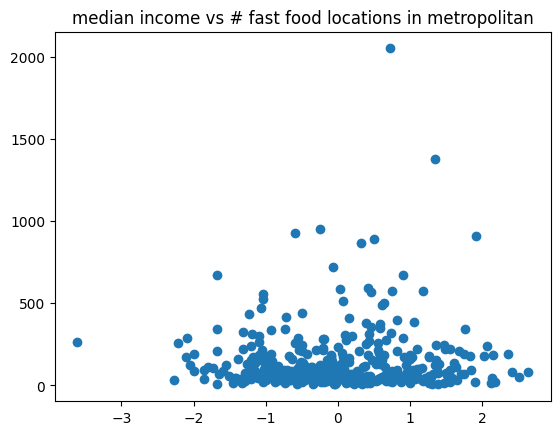

In [26]:
fig, ax = plt.subplots(1, 1)

temp = sim[sim.M_sim == 1]
ax.scatter(temp.I_sim, temp.F_sim)
ax.set_title('median income vs # fast food locations in metropolitan')

In [27]:
# test statistical model on simulated data
with pm.Model() as simulated_model:
    sigma = pm.Exponential('sigma', 1, shape=2)

    beta = pm.Normal('beta', 0, .5, shape=2)
    alpha = pm.Normal('alpha', 0, .2, shape=2)

    mu = pm.Deterministic('mu', beta[sim.M_sim] * sim.I_sim + alpha[sim.M_sim])

    f = pm.LogNormal("f", mu=mu, sigma=sigma[sim.M_sim], observed=sim.F_sim)

    simulated_idata = pm.sample(idata_kwargs={"log_likelihood": True})

az.summary(simulated_idata, var_names='~mu', kind='all')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.097,0.083,-0.039,0.226,0.001,0.001,5677.0,3445.0,1.0
alpha[1],4.130,0.063,4.026,4.228,0.001,0.001,3658.0,3222.0,1.0
beta[0],0.134,0.087,-0.008,0.268,0.001,0.001,4509.0,3246.0,1.0
beta[1],-0.009,0.058,-0.106,0.078,0.001,0.001,6216.0,3550.0,1.0
sigma[0],1.053,0.063,0.957,1.154,0.001,0.001,4769.0,3116.0,1.0
sigma[1],1.104,0.047,1.030,1.177,0.001,0.001,3736.0,2962.0,1.0


### Prior Predictive comments

While not perfect, the simulation does accurately capture how metropolitan areas will have a higher intercept for fast food restaurants, with positive 
slope associated with # of restaurants with increas in income. 

Actual model/data will reveal if our assumptions were correct.

## Model

We have tested 3 different models based on our assumptions on fast food locations per area:

1. **LogNormal**
2. **Poisson**
3. **NegativeBinomial**

- The LogNormal Model proved superior, demonstrating the best balance of complexity and predictive accuracy, making it ideal for our analysis. It effectively captured the variance and skewness in restaurant counts, using median income and area type as predictors.
- The Poisson and Negative Binomial Models were considered but showed less optimal performance. The Poisson model particularly suffered a bad fit as indicated by its high predictive information criteria scores and low effective model weight in cross-validation comparison.
- Model Comparison using LOO-CV (Leave-One-Out Cross-Validation) reinforced the LogNormal model's superiority, with it showing the highest log predictive density, indicating it is the most suitable for predicting new data without overfitting.

In [28]:
df['I'] = standardize(df['median_income'])
df['M'] = df.area_flag.apply(lambda el: (1 if el == 'M1' else 0))
df['F'] = df.ff_count.copy()
df

,area_flag,median_income,ff_count,I,M,F
0,M2,61026,10,0.140965,0,10
1,M1,54808,22,-0.370166,1,22
2,M2,53865,17,-0.447682,0,17
3,M1,57158,146,-0.176992,1,146
4,M2,39371,9,-1.639115,0,9
...,...,...,...,...,...,...
505,M1,69172,58,0.810580,1,58
506,M1,48558,110,-0.883927,1,110
507,M1,61307,23,0.164063,1,23
508,M1,46419,33,-1.059757,1,33


In [29]:
with pm.Model() as lognormal_model:
    sigma = pm.Exponential('sigma', 1, shape=2)

    beta = pm.Normal('beta', 0, .5, shape=2)
    alpha = pm.Normal('alpha', 0, .2, shape=2)

    M = pm.MutableData("M", df.M)
    I = pm.MutableData("I", df.I)

    mu = pm.Deterministic('mu', beta[M] * I + alpha[M])

    f = pm.LogNormal("f", mu=mu, sigma=sigma[M], observed=df.F, shape=M.shape[0])

    lognormal_idata = pm.sample(idata_kwargs={"log_likelihood": True})

az.summary(lognormal_idata, var_names='~mu', kind='all')

/Users/willemmirkovich/.venv/6053-final-project-lyJDXofz-py3.11/lib/python3.11/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],2.557,0.039,2.497,2.618,0.001,0.000,3212.0,3204.0,1.0
alpha[1],3.671,0.053,3.587,3.754,0.001,0.001,3892.0,2906.0,1.0
beta[0],-0.151,0.037,-0.210,-0.093,0.001,0.000,3574.0,3737.0,1.0
beta[1],0.399,0.052,0.321,0.486,0.001,0.001,4382.0,3025.0,1.0
sigma[0],0.374,0.025,0.336,0.413,0.000,0.000,3820.0,3178.0,1.0
sigma[1],1.011,0.039,0.947,1.071,0.001,0.000,4026.0,2998.0,1.0


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

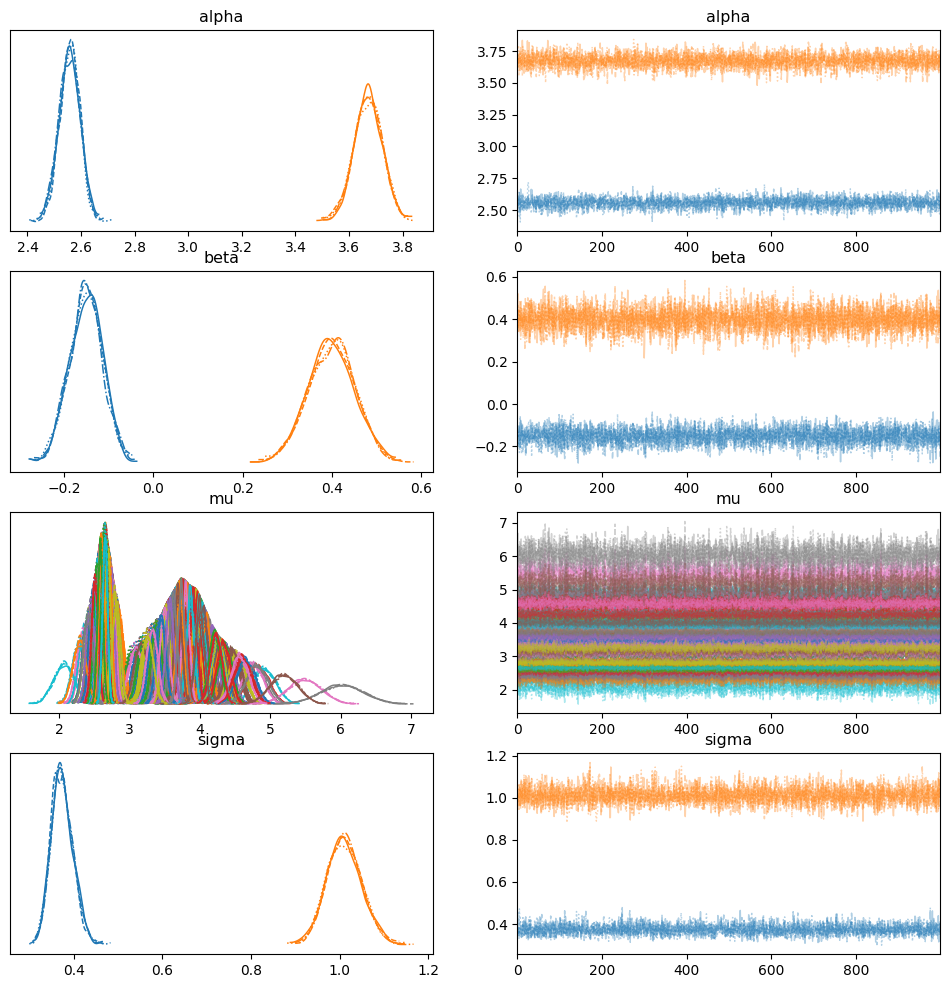

In [30]:
az.plot_trace(lognormal_idata,  figsize= (12, 12))

In [31]:
with pm.Model() as poisson_model:
    beta = pm.Normal('beta', 0, .5, shape=2)
    alpha = pm.Normal('alpha', 0, .2, shape=2)

    M = pm.MutableData("M", df.M)
    I = pm.MutableData("I", df.I)

    lam = pm.math.exp(alpha[M] + beta[M] * I)

    f = pm.Poisson("f", lam, observed=df.F, shape=M.shape[0])

    poisson_idata = pm.sample(idata_kwargs={"log_likelihood": True})

az.summary(poisson_idata, var_names='~mu', kind='all')

/Users/willemmirkovich/.venv/6053-final-project-lyJDXofz-py3.11/lib/python3.11/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.


/Users/willemmirkovich/.venv/6053-final-project-lyJDXofz-py3.11/lib/python3.11/site-packages/arviz/utils.py:142: UserWarning: Items starting with ~: ['mu'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],2.660,0.028,2.615,2.704,0.0,0.0,3205.0,2895.0,1.0
alpha[1],4.494,0.006,4.484,4.502,0.0,0.0,2911.0,3038.0,1.0
beta[0],-0.149,0.027,-0.190,-0.105,0.0,0.0,2911.0,2715.0,1.0
beta[1],0.444,0.003,0.439,0.449,0.0,0.0,3118.0,2952.0,1.0


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

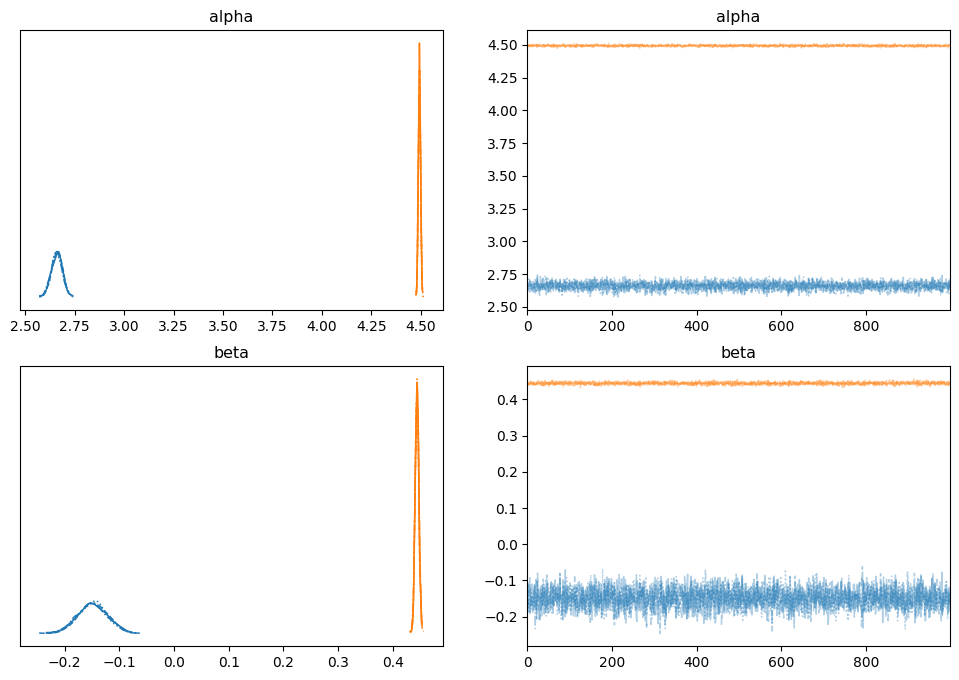

In [32]:
az.plot_trace(poisson_idata, figsize= (12, 8))

In [33]:
with pm.Model() as negbinom_model:
    beta = pm.Normal('beta', 0 , 0.01, shape=2)
    alpha = pm.Normal('alpha', mu=-1, sigma=1, shape=2)
    dispersion = pm.Gamma('dispersion', alpha=2, beta=0.1, shape=2)

    M = pm.MutableData("M", df.M)
    I = pm.MutableData("I", df.I)

    mu = pm.math.exp(alpha[M] + beta[M] * I) 

    f = pm.NegativeBinomial('f', mu=mu, alpha=dispersion[M], observed=df.F, shape=M.shape[0])

    negbinom_idata = pm.sample(idata_kwargs={'log_likelihood': True})

az.summary(negbinom_idata, var_names='~mu', kind='all')

/Users/willemmirkovich/.venv/6053-final-project-lyJDXofz-py3.11/lib/python3.11/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, dispersion]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.


/Users/willemmirkovich/.venv/6053-final-project-lyJDXofz-py3.11/lib/python3.11/site-packages/arviz/utils.py:142: UserWarning: Items starting with ~: ['mu'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],2.764,0.035,2.707,2.819,0.000,0.000,5812.0,3264.0,1.0
alpha[1],4.656,0.056,4.562,4.739,0.001,0.001,5652.0,3446.0,1.0
beta[0],-0.008,0.010,-0.023,0.008,0.000,0.000,6169.0,3302.0,1.0
beta[1],0.020,0.010,0.005,0.036,0.000,0.000,4299.0,3389.0,1.0
dispersion[0],12.306,2.740,7.744,16.034,0.035,0.027,7018.0,3286.0,1.0
dispersion[1],0.851,0.054,0.766,0.939,0.001,0.001,5091.0,3202.0,1.0


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'dispersion'}>,
        <Axes: title={'center': 'dispersion'}>]], dtype=object)

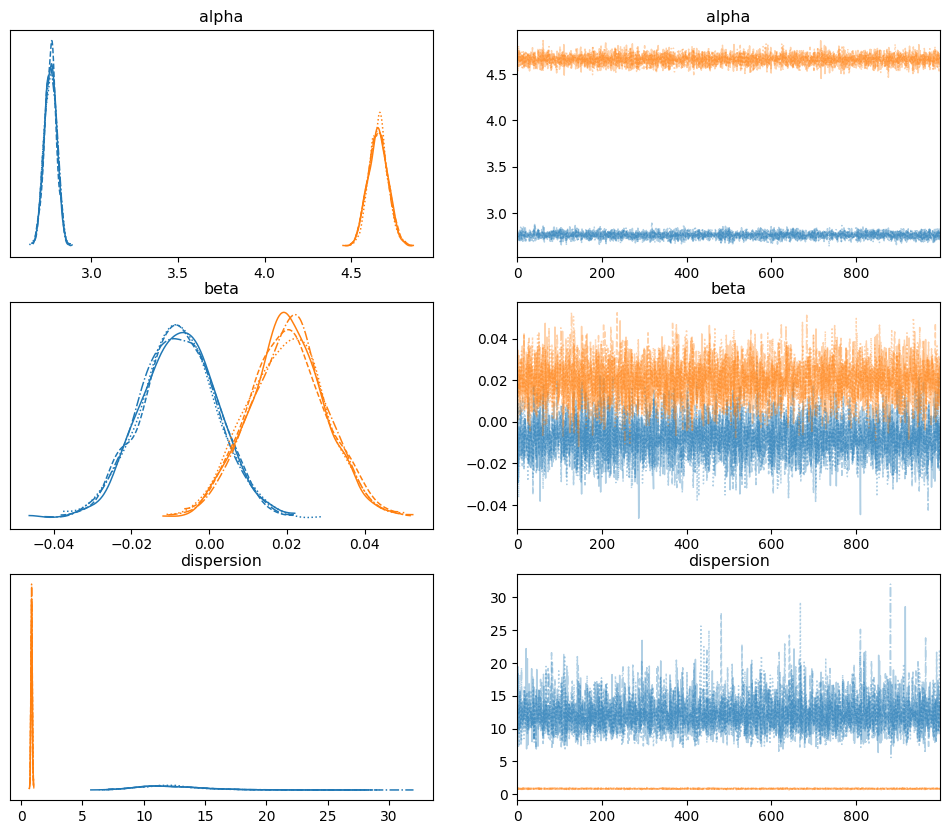

In [34]:
az.plot_trace(negbinom_idata, figsize= (12, 10))

In [35]:
model_dict = {
    'lognormal': lognormal_idata,
    'poisson': poisson_idata,
    "negbinomial": negbinom_idata
}
compare_df_psis = az.compare(
    compare_dict=model_dict,
    ic="loo",
    scale="deviance"
)
compare_df_psis

/Users/willemmirkovich/.venv/6053-final-project-lyJDXofz-py3.11/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
lognormal,0,4945.575878,5.823000,0.000000,1.000000e+00,82.508741,0.000000,False,deviance
negbinomial,1,5168.948757,7.045789,223.372879,1.121708e-11,86.906463,30.609808,False,deviance
poisson,2,59094.179611,484.259575,54148.603734,7.580603e-13,9637.036837,9587.735108,True,deviance


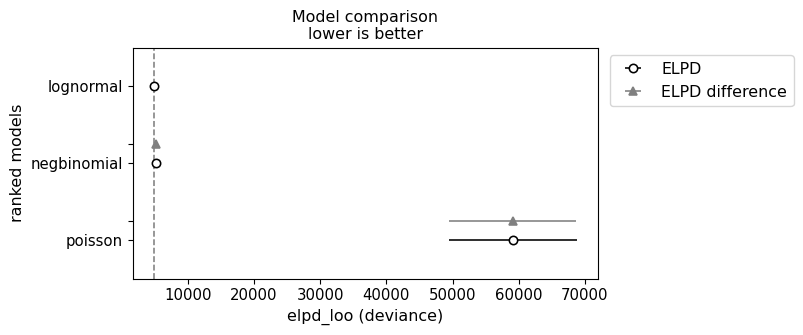

In [36]:
_ = az.plot_compare(compare_df_psis)

## Posterior Predictive Analysis

1. **Micropolitan Areas**
   - **Observation**: The graph shows a slight decrease in the predicted count of fast food restaurants as median income increases. The red line, representing the posterior mean, trends downward slightly amidst a wide confidence interval shaded in pink.
   - **Interpretation**: This indicates that in micropolitan areas, higher median incomes might be associated with a decrease in the number of fast-food restaurants, although the data points (blue dots) display considerable variability around the prediction.
2. **Metropolitan Areas**
   - **Observation**: There is a clear upward trend in the predicted number of fast food restaurants as median income increases, illustrated by the green line. The confidence interval, shaded in green, widens at higher income levels, suggesting increased uncertainty in the predictions as income rises.
   - **Interpretation**: This suggests that in metropolitan areas, higher median incomes are strongly associated with increases in the number of fast-food restaurants. The observed data points (blue dots) mostly cluster around the lower income levels but support the upward trend.
3. **Insights**:
    - The contrasting trends between micropolitan and metropolitan areas align with the estimand, affirming that area type significantly modifies the impact of median income on fast food restaurant prevalence.
    - The variability in both graphs, especially in the metropolitan data, underscores the influence of other unmodeled factors or inherent data variability that might affect restaurant counts.

Sampling: [f]


Output()

/Users/willemmirkovich/.venv/6053-final-project-lyJDXofz-py3.11/lib/python3.11/site-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
Sampling: [f]


Output()

/Users/willemmirkovich/.venv/6053-final-project-lyJDXofz-py3.11/lib/python3.11/site-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


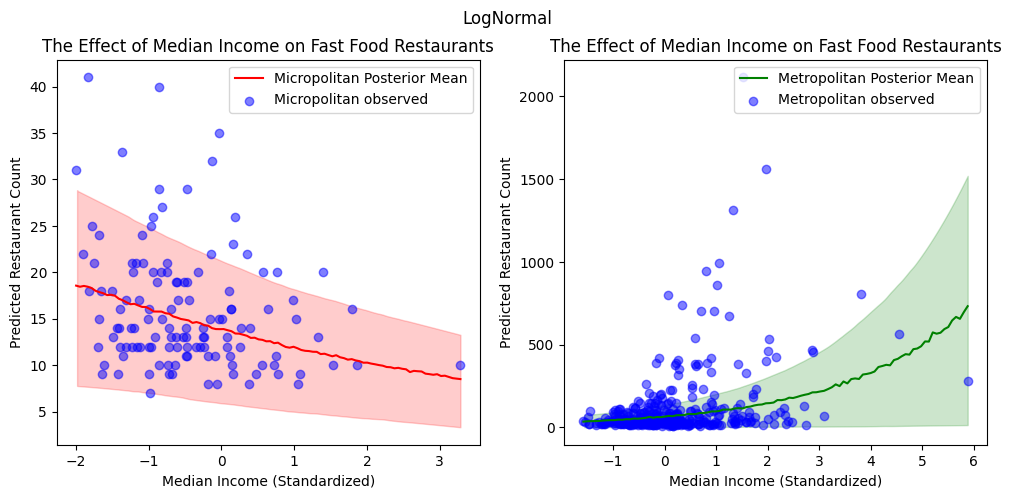

In [37]:
def plot_posterior_predictions(model, idata, title):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    args = zip(
        ['Micropolitan', 'Metropolitan'],
        [0, 1],
        axs,
        ['red', 'green']
    )

    for arg in args:

        t, f, ax, g = arg

        ns = 100
        I = df[df.M == f].I
        I_seq = np.array(np.linspace(I.min(), I.max(), ns))
        M_seq = np.array([f] * ns)


        with model:
            pm.set_data({"M": M_seq, "I": I_seq})
            f_pred = az.extract(
                    pm.sample_posterior_predictive(idata, var_names=["f"]),
                    group="posterior_predictive"
                )["f"]

        f_pred_mean = f_pred.mean("sample")
            
        obs = df[df.M == f]

        az.plot_hdi(I_seq, f_pred.T, color=g, fill_kwargs={"alpha": 0.2}, ax=ax)
        ax.plot(I_seq, f_pred_mean, label=f'{t} Posterior Mean', color=g)

        ax.scatter(obs.I, obs.F, color='blue', alpha=.5, label=f'{t} observed')
        ax.legend()
        ax.set_xlabel("Median Income (Standardized)")
        ax.set_ylabel("Predicted Restaurant Count")
        ax.set_title("The Effect of Median Income on Fast Food Restaurants")
        fig.suptitle(title)

plot_posterior_predictions(lognormal_model, lognormal_idata, 'LogNormal')
None

Sampling: [f]


Output()

/Users/willemmirkovich/.venv/6053-final-project-lyJDXofz-py3.11/lib/python3.11/site-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
Sampling: [f]


Output()

/Users/willemmirkovich/.venv/6053-final-project-lyJDXofz-py3.11/lib/python3.11/site-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


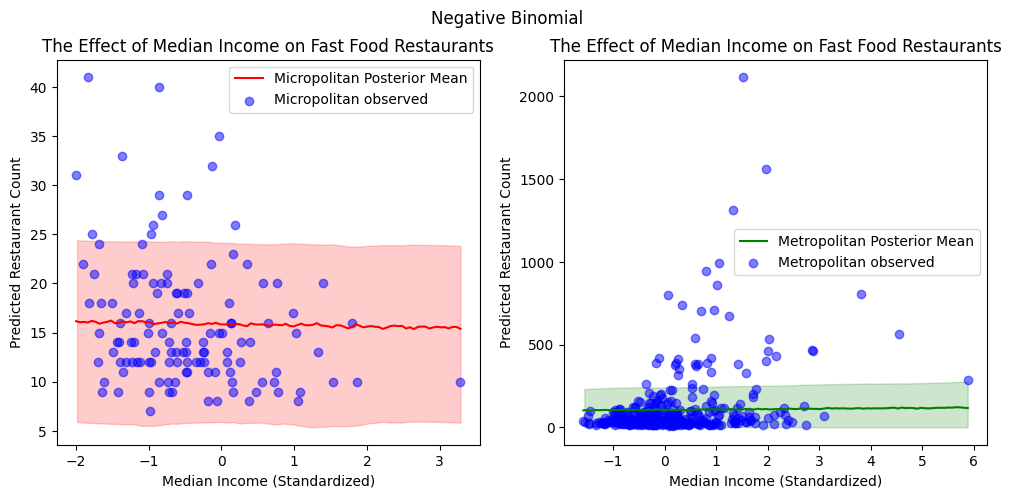

In [38]:
plot_posterior_predictions(negbinom_model, negbinom_idata, 'Negative Binomial')
None

Sampling: [f]


Output()

/Users/willemmirkovich/.venv/6053-final-project-lyJDXofz-py3.11/lib/python3.11/site-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
Sampling: [f]


Output()

/Users/willemmirkovich/.venv/6053-final-project-lyJDXofz-py3.11/lib/python3.11/site-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


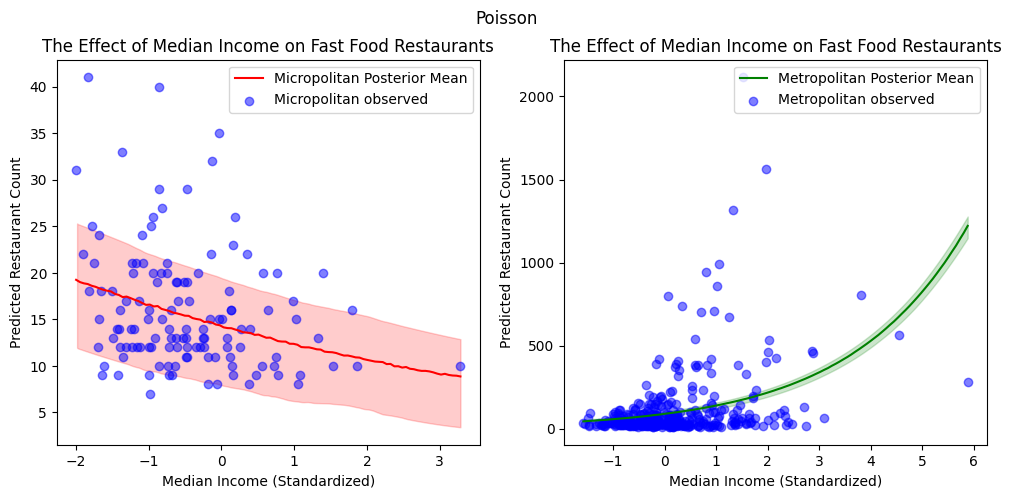

In [39]:
plot_posterior_predictions(poisson_model, poisson_idata, 'Poisson')
None

## Final Discussion

The estimand can be observed by the posterior predictive simulation plots, especially the ones done using the LogNormal Model. The model effectively reflects the estimand positive relationship in metropolitan areas and a negative trend in micropolitan areas, which seems to suggest that fast food deserts do exist in lower income areas.